In [374]:
import numpy as np
from pynput.mouse import Button, Controller
import mss
import re
import math
import matplotlib.pyplot as plt
import pytesseract
import subprocess
import cv2
import time
from PIL import Image

In [375]:
# slither.io: half-split screen of chrome, with bookmark menu
#
x_pad = 640
y_pad = 100
with mss.mss() as sct:
    mon0 = sct.monitors[0]
    monitor = {'top': y_pad, 'left': x_pad, 'width': 1280 - x_pad, 'height': 700 - y_pad}
    sh = sct.grab(monitor)
    x = np.asarray(sh)
    x = x[::2, ::2, :-1]

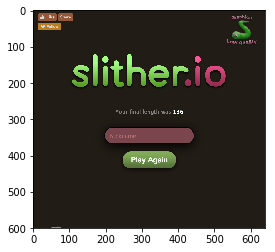

In [376]:
pytesseract.image_to_string(Image.fromarray(x) )
x.shape
plt.imshow(x)
plt.show()

In [377]:
def get_coords(menu):
    coords_dict = {
        "ending": (956, 513),
        "skip_ad": (1200, 780),
        "playing": (960, 450)
    }
    return coords_dict[menu]

In [378]:
# during playing
score_width = 24
score_height = 16

# allow for 36 bins of movement
angle_bins = 36.0

# death detection relative to x_pad and y_pad
detect_x = 120
detect_y = 0
detect_width = 400
detect_height = 110

# score relative to x_pad and y_pad
score_x = 86
score_y = 660
score_width = 50
score_height = 15

# delay time for every action
action_delay = 0.05

# skip_ad detection
skip_x = 160
skip_y = 670
skip_width = 320
skip_height = 20


mouse = Controller()

In [379]:
# state is image
def restart(state):
    detect_area = state[detect_y:detect_y+detect_height,detect_x:detect_x+detect_width]
#     plt.imshow(detect_area)
#     plt.show()
#     temp = np.asarray([22,28,34]* int(detect_area.size / 4) ).reshape((detect_area.shape[0], detect_area.shape[1], 4))
    max_diff = np.amax(np.fabs(detect_area - np.array([22,28,34])) )
    if max_diff > 15:
        print("in the game",end="\r")
    else:
        print("dead",end="\r")
#         x,y = get_coords("ending")
#         mouse.position = (x,y)
#         mouse.press(Button.left)
#         mouse.release(Button.left)

In [395]:
# last_score is reset everytime when the game finished
last_score = 0
idx = 0

def get_score(state):
    global last_score
    detect_area = state[score_y:score_y+score_height,score_x:score_x+score_width]
#     plt.imshow(detect_area)
#     plt.show()
    diff = np.fabs(detect_area - np.array([206,206,206]) )
    res = np.array([[255,255,255] if np.amax(i) < 10 else [0,0,0] for i in diff.reshape((-1,3))]).reshape(detect_area.shape).astype(np.uint8)
    
    img = Image.fromarray(res.astype(np.uint8))
    img.save("testing.png")
    cmd = "tesseract testing.png stdout -c tessedit_char_whitelist=0123456789 -psm 6"
    string = subprocess.check_output(cmd, shell=True)
    string = re.sub("[^0-9]","",str(string) )
#     string = pytesseract.image_to_string(img, config="-c tessedit_char_whitelist=0123456789 -psm 6")
    if(not len(string.strip()) == 0):
        try:
            score = int(string.strip() )
        except:
            img.save("error{}.png".format(idx))
            idx += 1
            return None
        if(score > 10):
            if((last_score >= score and last_score - score < 10) 
               or (score >= last_score and score - last_score < 500) ):
                print(score,end=" ")
                last_score = score
        else:
            return None
    else:
        return None
#     ret, binarize = cv2.threshold(detect_area, 200, 255, cv2.THRESH_BINARY) 
#     result = Image.fromarray(binarize)
#     result.save("testing.png")
#     cmd = "tesseract testing.png stdout -c tessedit_char_whitelist=0123456789 -psm 6"
#     score = subprocess.check_output(cmd, shell=True)
#     print(score, end="\r")
#     plt.imshow(binarize)
#     plt.show()
#     result = Image.fromarray(detect_area)
#     result.save("testing.png")
#     print(pytesseract.image_to_string(Image.open('/Users/ximinlin/Desktop/twntyone.png') ) )
#     score = int(pytesseract.image_to_string(Image.fromarray(detect_area) ) )
#     print(score)

In [396]:
# action defines clicking or not
# for click or not, each case with 36 choice bins for 360 degrees
# assume about 30 pixels from the head of snake
def move_mouse(action):
    haed_x, head_y = get_coords("playing")
    xm = int(30 * np.cos(math.radians(action / angle_bins * 360) ) + head_x )
    ym = int(30 * np.sin(math.radians(action / angle_bins * 360) ) + head_y )
    mouse.position = (xm, ym)
    if action >= 36:
        mouse.press(Button.left)
    else:
        mouse.release(Button.left)
    time.sleep(action_delay)

In [397]:
def skip_ad(state):
    detect_area = state[skip_y:skip_y+skip_height,skip_x:skip_x+skip_width]
    max_diff = np.amax(np.fabs(detect_area - np.array([3,4,5]) ) )
    if max_diff > 25:
        print("no ad", end="\r")
    else:
        print("ad", end="\r")
        xm,ym = get_coords("skip_ad")
        mouse.position = (xm,ym)
        mouse.press(Button.left)
        time.sleep(0.1)
        mouse.release(Button.left)

In [400]:
def test_without_control():
    mon0 = sct.monitors[0]
    monitor = {'top': y_pad, 'left': x_pad, 'width': 1280 - x_pad, 'height': 800 - y_pad}
    sh = sct.grab(monitor)
    x = np.asarray(sh)
    x = x[::2, ::2, :-1]
#     plt.imshow(x)
#     plt.show()
    get_score(x)

while True:
    test_without_control()
#     break

410 

KeyboardInterrupt: 

In [ ]:
def test_with_control():
    x,y = get_coords("ending")
    mouse.position = (x,y)
    mouse.press(Button.left)
    mouse.release(Button.left)